In [1]:
# import fastai
from fastai.vision.all import *

In [2]:
import os
from dotenv import load_dotenv
load_dotenv() 
# Path to dataset
path = Path(os.getenv("DATASET_PATH"))

# DataLoaders with built-in augmentation
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,       # 80/20 split
    seed=42,             # reproducibility
    bs=32,               # batch size
    item_tfms=Resize(460, method=ResizeMethod.Squish, pad_mode='zeros'),  # resize before augmentation
    batch_tfms=[
        *aug_transforms(  # fastai's smart augmentations
            size= 224,
            do_flip=True,
            flip_vert=False,
            max_rotate=10,
            max_zoom=1.1,
            min_scale=0.9,
            max_warp=0.05,
            p_affine=0.5,
            p_lighting=0.7
            
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [4]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD
)


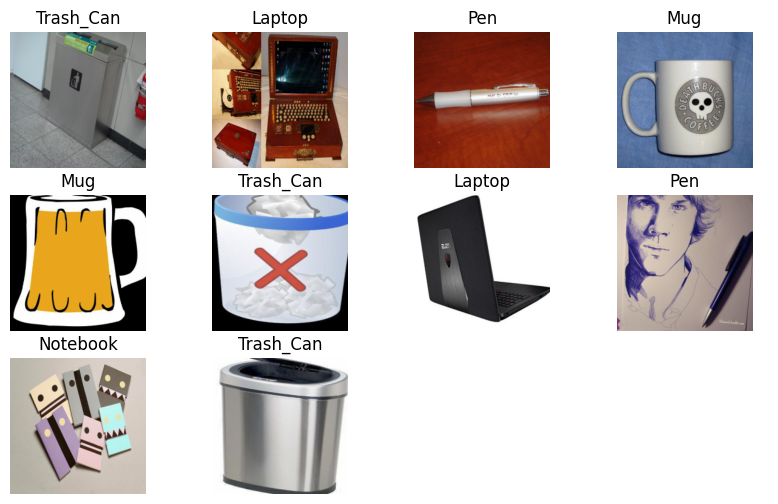

In [3]:
dls.show_batch(max_n=10, figsize=(10,6))

In [5]:
# print classes
print(dls.vocab)

['Backpack', 'Chair', 'File_Cabinet', 'Laptop', 'Mouse', 'Mug', 'Notebook', 'Pen', 'Table', 'Trash_Can']


SuggestedLRs(valley=0.013182567432522774)

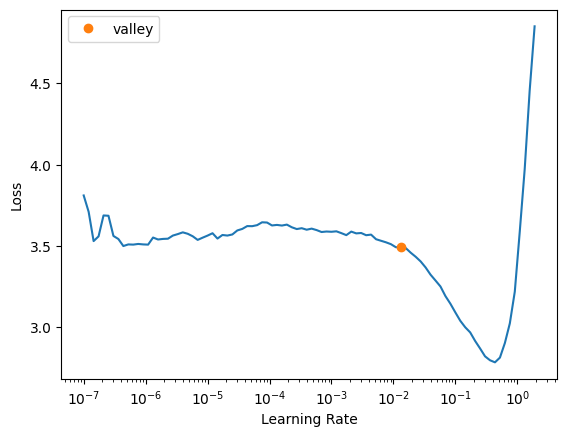

In [6]:
# Find learning rate
learn.lr_find()

Take the learning rate before the loss sharply increases so, taking learning rate of 2e-2

In [8]:
# freeze petrained layers
learn.freeze()

# train head for r epoch with learning rate of 2e-2
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.356618,0.208775,0.933460,08:04
1,0.328610,0.187971,0.931559,04:14
2,0.274220,0.171968,0.944867,05:02
3,0.250374,0.158681,0.946768,05:39
4,0.232409,0.163304,0.942966,05:42


SuggestedLRs(valley=0.00013182566908653826)

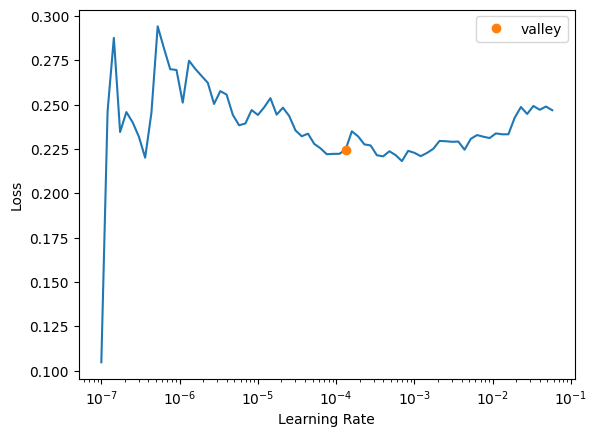

In [10]:
#unfreeze model and find learning rate
learn.unfreeze()
learn.lr_find()


The learning rate range is (1e-6, 1e-4)

In [11]:
# import callback
from fastai.callback.all import *
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3)

In [12]:
#fine tune the entire model
learn.fit_one_cycle(8, lr_max=slice(1e-6,1e-4), cbs=[early_stop])

epoch,train_loss,valid_loss,accuracy,time
0,0.223728,0.162329,0.946768,08:10
1,0.221372,0.164523,0.946768,07:57
2,0.233008,0.165195,0.944867,07:52
3,0.234004,0.161035,0.944867,07:25
4,0.220296,0.158756,0.948669,08:10
5,0.227328,0.154574,0.950570,08:49
6,0.219674,0.156928,0.952471,10:06
7,0.203921,0.166485,0.941065,10:25


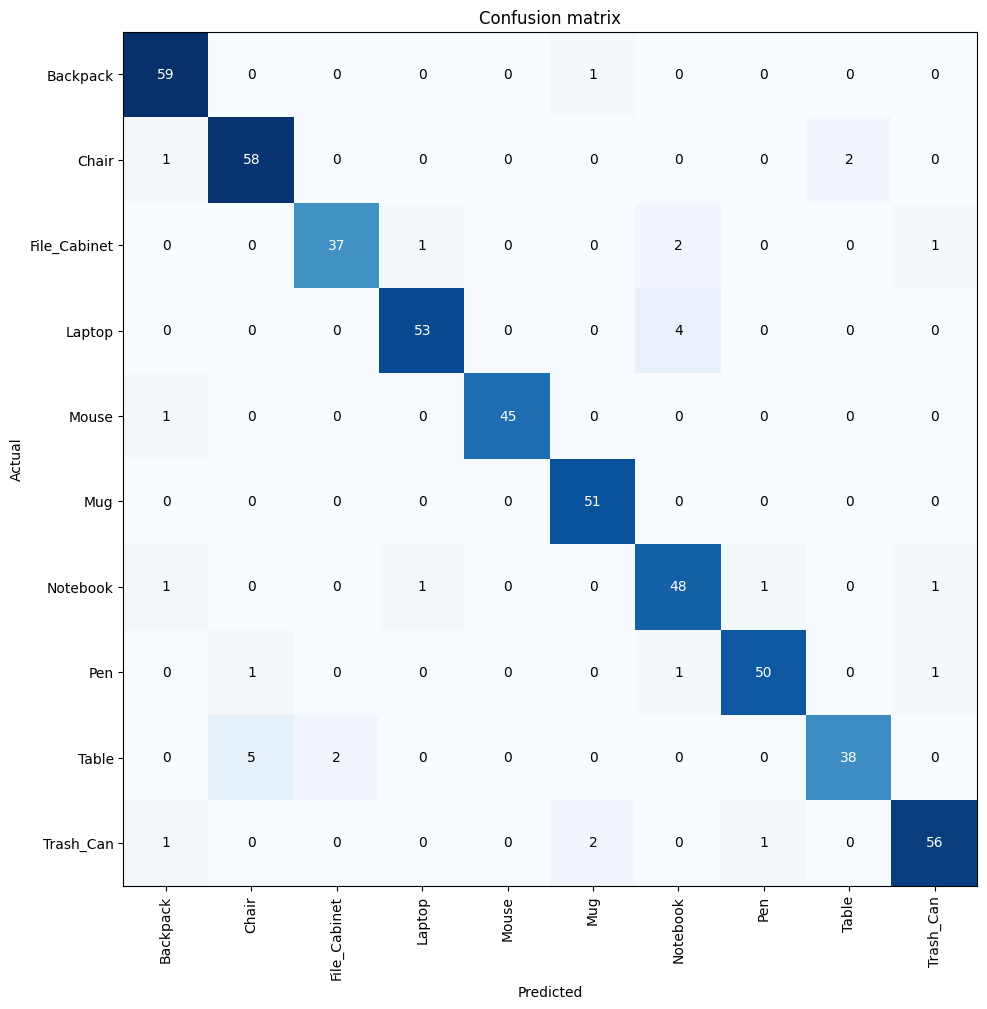

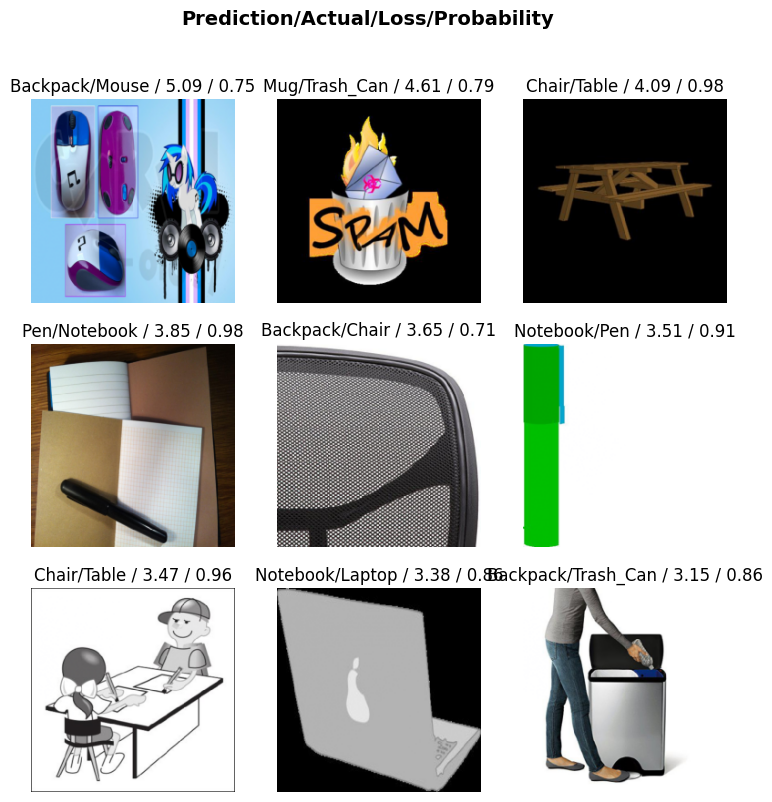

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.plot_top_losses(9, nrows=3)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Get predictions
preds, targs = learn.get_preds()

# Convert probabilities to class indices
pred_classes = preds.argmax(dim=1)
true_classes = targs

# Get class labels
labels = learn.dls.vocab

# Compute metrics
f1 = f1_score(true_classes, pred_classes, average='weighted')
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')


print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


F1 Score: 0.9409012267208282
Precision: 0.9420258757938802
Recall: 0.94106463878327
